# *Segmentation of Graffiti Letters*

My final project revolves around graffiti. Here/I explored the task of segmenting graffiti letters into its own individual letters. 
### Clustering Segmentation

Here I attempted to segment the letters through clustering. First I would segment the graffiti from the background. Then I would once again run it on the graffiti in attempt to segment out the letters. We will see this attempt will fail as the feature vectors didn't contain information for the specific letter, rather just color or position.


In [24]:
from project_2.segmentation import kmeans_fast, color_features
from PIL import Image
import random
random.seed(10)
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

/var/folders/_2/z3y9wxgj75180383fmbznn9r0000gn/T/ipykernel_12103/3304722101.py:8: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((new_width, new_height), Image.LANCZOS)


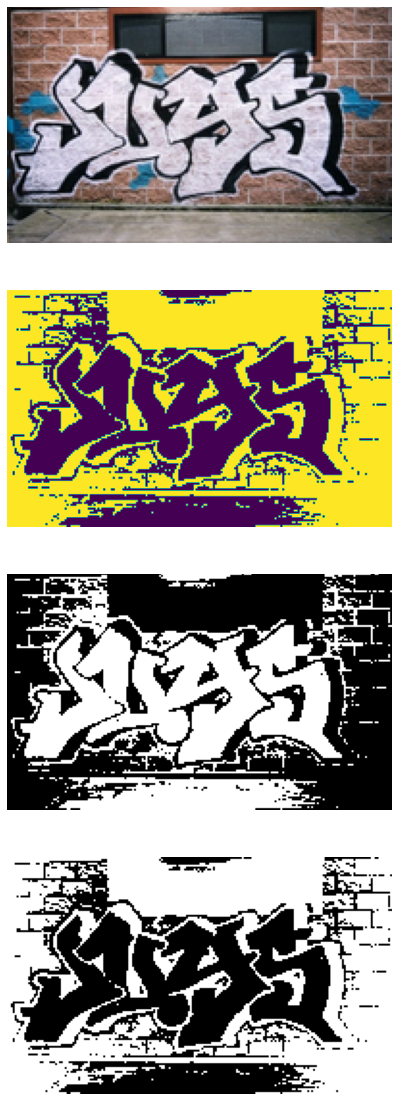

In [50]:
img_path = "data/graf_pic_2.jpeg"
img = Image.open(img_path)
W, H = img.size

# scale iamge to 500 pix width
new_width = 200
new_height = int(new_width * H / W)
img = img.resize((new_width, new_height), Image.LANCZOS)


# Extract pixel-level features
img = np.asarray(img)
H, W, C = img.shape
num_segments = 2
features = color_features(img)

# Run clustering algorithm
assignments = kmeans_fast(features, num_segments)

segments = assignments.reshape((H, W))

# Display segmentation
N = num_segments + 2
fig, axes = plt.subplots(N, 1, figsize=(15, 20))
axes[0].imshow(img)
axes[0].axis('off')

axes[1].imshow(segments, cmap="viridis")
axes[1].axis('off')

# turn non part segments to 0 (black)
segment1 = np.where(segments != 0, 0, 1)
axes[2].imshow(segment1, cmap="gray")
axes[2].axis('off')

segment2 = np.where(segments != 1, 0, 1)
axes[3].imshow(segment2, cmap="gray")
axes[3].axis('off')

# segment3 = np.where(segments != 2, 0, 1)
# axes[4].imshow(segment3, cmap="gray")
# axes[4].axis('off')

# segment4 = np.where(segments != 3, 0, 1)
# axes[5].imshow(segment4, cmap="gray")
# axes[5].axis('off')

plt.show()


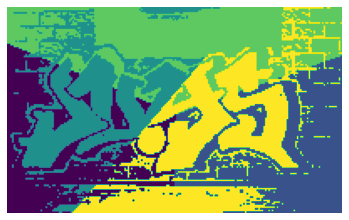

In [51]:
# Segment based off color and position.
from project_2.segmentation import color_position_features
b_segment = segment1
b_segment = np.reshape(b_segment, (b_segment.shape[0], b_segment.shape[1], 1))
H, W, C = b_segment.shape
num_segments = 5
features = color_position_features(b_segment)

# Run clustering algorithm
assignments = kmeans_fast(features, num_segments)

segments = assignments.reshape((H, W))

plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


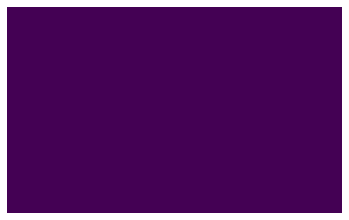

In [43]:
# Just color would fail as it is a black and white image
features = color_features(b_segment)

# Run clustering algorithm
assignments = kmeans_fast(features, num_segments)

segments = assignments.reshape((H, W))

plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

### Edge and Region Segmentation

I would then attempt to use the edges to segment the image and fill the holes as to segment. This would also fail as the edges aren't perfectly drawn and connected.

Text(0.5, 1.0, 'Canny detector')

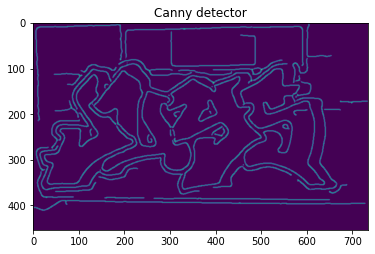

In [44]:
from skimage.feature import canny
import scipy.ndimage as nd

img = io.imread(img_path, as_gray=True)

edges = canny(img, sigma=4)
plt.imshow(edges, interpolation='gaussian')
plt.title('Canny detector')

Text(0.5, 1.0, 'Region Filling')

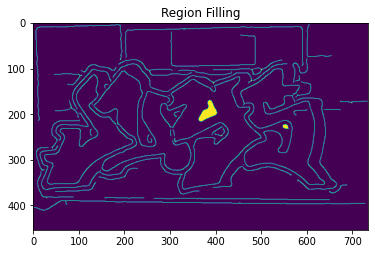

In [45]:
fill_im = nd.binary_fill_holes(edges)
plt.imshow(fill_im)
plt.title('Region Filling')

### Watershed Segmentation

I would then use watershed segmentation. This would prove succesfull for segmenting the letters out of the graffiti

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3444: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


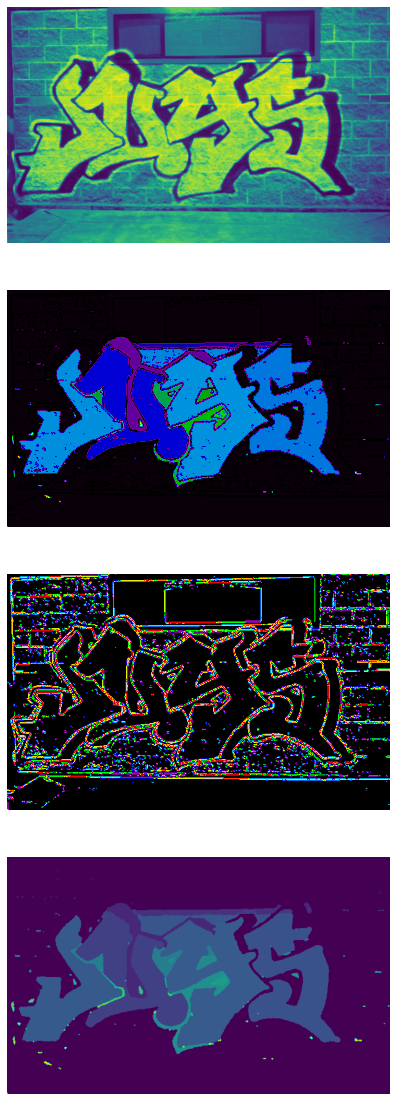

In [46]:
from skimage import segmentation
from skimage.filters import rank
from skimage.morphology import disk
from scipy import ndimage as ndi

denoised = rank.median(img)
markers = rank.gradient(denoised, disk(1)) < 40
markers = ndi.label(markers)[0]
gradient = rank.gradient(denoised, disk(1)) > 40

segmentation_letters = segmentation.watershed(gradient, markers)

fig, axes = plt.subplots(4, 1, figsize=(15, 20))
axes[0].imshow(denoised)
axes[0].axis('off')

axes[1].imshow(markers, cmap=plt.cm.nipy_spectral)
axes[1].axis('off')

# turn non part segments to 0 (black)
axes[2].imshow(gradient, cmap=plt.cm.nipy_spectral)
axes[2].axis('off')

axes[3].imshow(segmentation_letters, cmap="viridis")
axes[3].axis('off')

plt.show()


In [47]:
unique_values, counts = np.unique(segmentation_letters.flatten(), return_counts=True)
sorted_indices = np.argsort(-counts)
#Get the 5 biggest masks. The first one is the background, but the following are the letters/
for i in range(5):  # Change 5 to the number of top values you want
    print(f"Value: {unique_values[sorted_indices[i]]}, Count: {counts[sorted_indices[i]]}")

Value: 1, Count: 226069
Value: 63, Count: 26145
Value: 55, Count: 22436
Value: 42, Count: 20179
Value: 62, Count: 17198


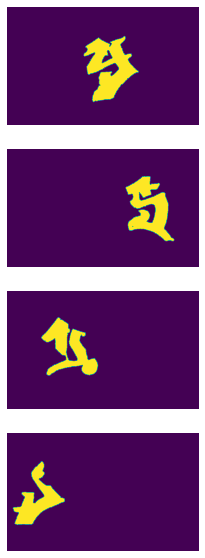

In [48]:
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
unique_segment_3 = np.where(segmentation_letters != 62, 0, 1)
axes[3].imshow(unique_segment_3)
axes[3].axis('off')

unique_segment_0 = np.where(segmentation_letters != 63, 0, 1)
axes[0].imshow(unique_segment_0)
axes[0].axis('off')

unique_segment_1 = np.where(segmentation_letters != 55, 0, 1)
axes[1].imshow(unique_segment_1)
axes[1].axis('off')

unique_segment_2 = np.where(segmentation_letters != 42, 0, 1)
axes[2].imshow(unique_segment_2)
axes[2].axis('off')

plt.show()